In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

train_dir = 'D:/Ml2/Dataset/Training'  # Replace with the actual path
test_dir = 'D:/Ml2/Dataset/Testing' 

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [4]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

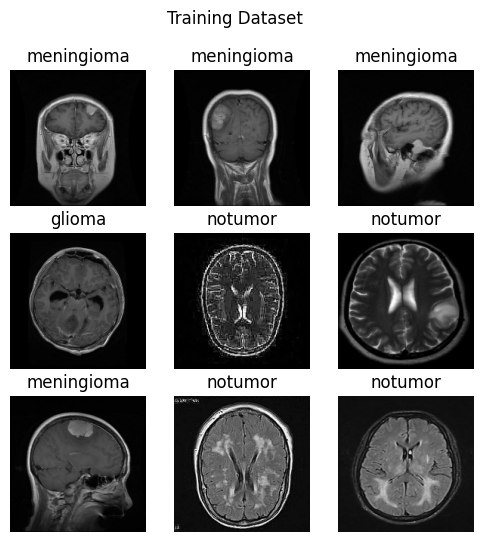

In [6]:
# Show images function
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_ds, "Training Dataset")

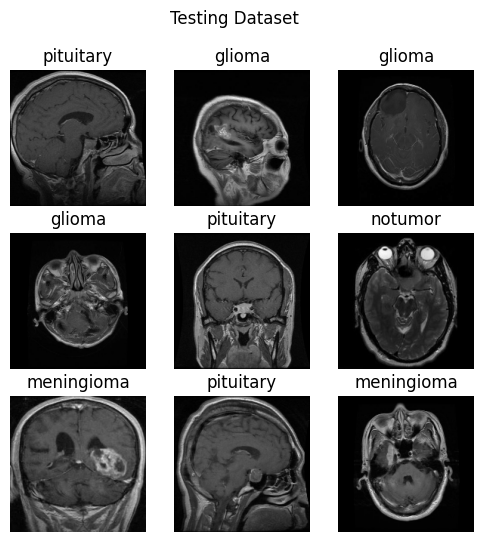

In [7]:
show_images(test_ds, 'Testing Dataset')

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [10]:
test_set = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [11]:
# Function to extract HOG features
def extract_hog_features(image):
    image = (image * 255).astype(np.uint8)  # Ensure image is in the correct format
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                   orientations=9, block_norm='L2-Hys', visualize=False)
    return features

# Prepare data for feature extraction
def prepare_data(dataset):
    features = []
    labels = []
    for images, lbl in dataset:
        for img, label in zip(images, lbl):
            img = img.numpy().astype('uint8')  # Convert tensor to numpy array
            feature = extract_hog_features(img)
            features.append(feature)
            labels.append(label.numpy())  # Append the label
    return np.array(features), np.array(labels)


In [12]:
# Extract features from the training and test datasets
X_train, y_train = prepare_data(train_ds)
X_test, y_test = prepare_data(test_ds)

In [13]:
# Train Random Forest model
def train_random_forest(X_train, y_train):
    print("Training Random Forest Classifier...")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    return rf_classifier

In [14]:
# Train the model
rf_classifier = train_random_forest(X_train, y_train)

Training Random Forest Classifier...


In [15]:
# Evaluate the Random Forest model on the test data
y_pred = rf_classifier.predict(X_test)

In [16]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.85%


In [17]:
# Precision, Recall, F1-Score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.78      0.85       300
  meningioma       0.82      0.85      0.84       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.90      0.97      0.93       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311




Confusion Matrix:



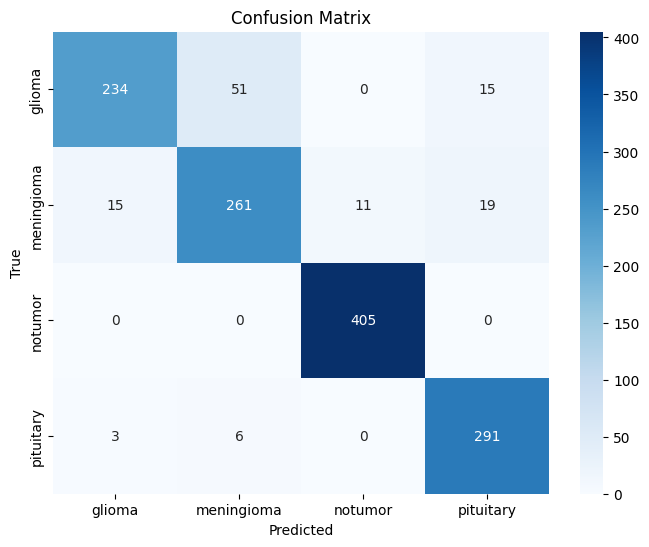

In [18]:
# Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import joblib
# Save the model
joblib.dump(rf_classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [20]:
# Function to predict custom images using the trained model
def predict_image(image_path):
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image) / 255.0  # Rescale
    features = extract_hog_features(image)  # Extract HOG features
    features = features.reshape(1, -1)  # Reshape for the model input
    prediction = rf_classifier.predict(features)
    return class_names[prediction[0]]

# Example of predicting a custom image
custom_image_path = 'D:/Ml2/Dataset/Testing/pituitary/Te-pi_0010.jpg'  # Replace with your image path
prediction_result = predict_image(custom_image_path)
print(f'Predicted class: {prediction_result}')

Predicted class: pituitary
